In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os import path as op
import itertools
import re
import xarray as xr
from sklearn.model_selection import train_test_split
import numpy.random as nr

%matplotlib inline

/scratch/adomakor412/conda/envs/MyEnv/lib/python3.6/site-packages/dask/config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
nr.seed = 42

In [3]:
inputPath = '/scratch/adomakor412/july_25-26_2019_npy'
PATH = os.path.expanduser(inputPath)
ncPath = os.path.expanduser('/scratch/adomakor412/july_25-26_2019')

In [4]:
columns = [
    "time",
    "longitude",
    "latitude",
    #"band",#Necessary?
    "G17_Temp",
    "G17_mean",
    "G17_std",#mean and std outside inner for loop for comp. eff.
    "target_G16_Temp"
]

df = pd.DataFrame({},columns = columns)

In [5]:
def longitude(lonMin, lonMax, col, colSize):
    lon = (col/colSize)* (lonMax - lonMin)
    return lon

def latitude(latMin, latMax, row, rowSize):
    lat = (row/rowSize)* (latMax - latMin)
    return lat

def Rad2BT(rad, planck_fk1, planck_fk2, planck_bc1, planck_bc2):
    """Radiances to Brightness Temprature (using black body equation)"""
    invRad = np.array(rad)**(-1)
    arg = (invRad*planck_fk1) + 1.0
    T = (- planck_bc1+(planck_fk2 * (np.log(arg)**(-1))) )*(1/planck_bc2) 
    return T

In [6]:
import logging
logger = logging.getLogger()

In [7]:
extent_pc = [-109.59326, -102.40674, 8.94659, -8.94656]

# Generate a fixed test set of size 10^5 of random pixels to be compared to training sets. We create a fixed test set for both MLP and pCal.

In [9]:
dfFixed_ML = []#df.iloc[[inds]]
dfFixed_pCal = []

trainSamp = [100000]

for samp in trainSamp:
    dataFrames = []
    with open('logML', 'a') as log:
        for (bb,dd,SS) in list(itertools.product([8],[206,207],[17])):
            DD = str(dd).zfill(3)
            lookup = f'M6C08_G{SS}_s2019{DD}1200'
            ncFiles = [f for f in os.listdir(ncPath) if re.search(lookup,f)]
            #ncFiles = mySort(ncFiles)
            npFiles = [f for f in os.listdir( PATH ) if re.search(lookup,f)] #Numpy files not fully data cleaned
            #ncFiles = mySort(ncFiles)
            
            #randInds = nr.randint(samp, size=(x*y))
            #randInds.sort()

            for ncf, npf in zip(ncFiles,npFiles):#for ncf, npf in zip(ncFiles,npFiles)[randInds] day sample <=576
                try:
                    imageBox = np.load(op.join( PATH,npf))
                    myFile = xr.open_dataset(op.join(ncPath,ncf))
                    planck_fk1 = float(myFile['planck_fk1'].data)
                    planck_fk2 = float(myFile['planck_fk2'].data) 
                    planck_bc1 = float(myFile['planck_bc1'].data)                       
                    planck_bc2 = float(myFile['planck_bc2'].data)

                    time = ncf[31:38]
                    G17_mean = Rad2BT(imageBox.mean(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)
                    G17_std = Rad2BT(imageBox.std(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)

                    hh = ncf[34:36]
                    mm = ncf[36:38]

                    print(str(ncf), file=log)
                    logger.info(str(ncf))

                    G16_npy = np.load( op.join(PATH, npf.replace('G16','G17',1)) )
                    G16_ncf = xr.open_dataset(op.join( ncPath, ncf.replace('G16','G17',1) ))
                    G16_fk1 = float(G16_ncf['planck_fk1'].data)
                    G16_fk2 = float(G16_ncf['planck_fk2'].data) 
                    G16_bc1 = float(G16_ncf['planck_bc1'].data)                       
                    G16_bc2 = float(G16_ncf['planck_bc2'].data)

                    target_G16_Temp = Rad2BT(G16_npy, G16_fk1, G16_fk2, G16_bc1, G16_bc2)
                    x,y = imageBox.shape[0],imageBox.shape[1]

                    #select "10,000" random points out of 401,401
                    sample = np.array([combo for combo in itertools.product(range(x),range(y))])
                    inds=nr.randint(x*y, size=(samp))
                    inds.sort()
                    
                    for i,j in sample[inds]:#bottleneck for time
                        lon = longitude( extent_pc[0], extent_pc[1], i, x )
                        lat = latitude( extent_pc[2], extent_pc[3], j, y)

                        G17_Temp = Rad2BT(imageBox[i,j], planck_fk1, planck_fk2, planck_bc1, planck_bc2)#nonfilter
                        target_G16_Temp = Rad2BT( G16_npy[i,j], G16_fk1, G16_fk2, G16_bc1, G16_bc2 )

                        row = [time, lon, lat, G17_Temp, G17_mean, G17_std, target_G16_Temp]

                        dataFrames.append(pd.DataFrame([row],columns=columns))
                        #concatenate a list of single dataframes after done with loop for speed " pandas.concat"
                        #z score versus the standard deviation for single image, can normalize across all image
                 
                    print('Wrapping up on sample')

                    df=pd.concat(dataFrames)
                    df = df.dropna()
                    df = df[ df["G17_Temp"] > 0]
                    df = df[ df["target_G16_Temp"] > 0]

                    dfSample = df#df.sample(n=samp)

                    if int(DD) == 206:#non pCal
                        print('Working on MLP sample')
                        dfFixed_ML = dfSample

                    if int(DD) == 207:#pCal        
                        print('Working on pCal sample')
                        dfFixed_pCal = dfSample
                        
                except ValueError as e:
                    logger.exception(e)
                    print(e)
                    print(e, file=log)
                    continue
        

Wrapping up on sample
Working on MLP sample
Wrapping up on sample
Working on pCal sample


# Now, we generate the training sets of various sizes.

In [10]:
inputPath = '/scratch/adomakor412/july_25-26_2019_npy'
PATH = os.path.expanduser(inputPath)
ncPath = os.path.expanduser('/scratch/adomakor412/july_25-26_2019')

MAE_ML = []
MSE_ML = []
R2_ML = []
R2_ML_train_test = []

MAE_pCal = []
MSE_pCal = []
R2_pCal = []
R2_pCal_train_test = []

dfTest_ML = []#df.iloc[[inds]]
dfTest_pCal = []#

trainSamp = [100, 1000, 10000, 100000]

for samp in trainSamp:
    dataFrames = []
    with open('logML', 'a') as log:
        for (bb,dd,SS) in list(itertools.product([8],[206,207],[17])):
            DD = str(dd).zfill(3)
            lookup = f'M6C08_G{SS}_s2019{DD}1200'
            ncFiles = [f for f in os.listdir(ncPath) if re.search(lookup,f)]
            #ncFiles = mySort(ncFiles)
            npFiles = [f for f in os.listdir( PATH ) if re.search(lookup,f)]
            #ncFiles = mySort(ncFiles)
            
            #randInds = nr.randint(samp, size=(x*y))
            #randInds.sort()

            for ncf, npf in zip(ncFiles,npFiles):#for ncf, npf in zip(ncFiles,npFiles)[randInds] day sample <=576
                try:
                    imageBox = np.load(op.join( PATH,npf))
                    myFile = xr.open_dataset(op.join(ncPath,ncf))
                    planck_fk1 = float(myFile['planck_fk1'].data)
                    planck_fk2 = float(myFile['planck_fk2'].data) 
                    planck_bc1 = float(myFile['planck_bc1'].data)                       
                    planck_bc2 = float(myFile['planck_bc2'].data)

                    time = ncf[31:38]
                    G17_mean = Rad2BT(imageBox.mean(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)
                    G17_std = Rad2BT(imageBox.std(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)

                    hh = ncf[34:36]
                    mm = ncf[36:38]

                    print(str(ncf), file=log)
                    logger.info(str(ncf))

                    G16_npy = np.load( op.join(PATH, npf.replace('G16','G17',1)) )
                    G16_ncf = xr.open_dataset(op.join( ncPath, ncf.replace('G16','G17',1) ))
                    G16_fk1 = float(G16_ncf['planck_fk1'].data)
                    G16_fk2 = float(G16_ncf['planck_fk2'].data) 
                    G16_bc1 = float(G16_ncf['planck_bc1'].data)                       
                    G16_bc2 = float(G16_ncf['planck_bc2'].data)

                    target_G16_Temp = Rad2BT(G16_npy, G16_fk1, G16_fk2, G16_bc1, G16_bc2)
                    x,y = imageBox.shape[0],imageBox.shape[1]

                    #select "10,000" random points out of 401,401
                    sample = np.array([combo for combo in itertools.product(range(x),range(y))])
                    inds=nr.randint(x*y, size=(samp))
                    inds.sort()
                    
                    for i,j in sample[inds]:#bottleneck for time
                        lon = longitude( extent_pc[0], extent_pc[1], i, x )
                        lat = latitude( extent_pc[2], extent_pc[3], j, y)

                        G17_Temp = Rad2BT(imageBox[i,j], planck_fk1, planck_fk2, planck_bc1, planck_bc2)#nonfilter
                        target_G16_Temp = Rad2BT( G16_npy[i,j], G16_fk1, G16_fk2, G16_bc1, G16_bc2 )

                        row = [time, lon, lat, G17_Temp, G17_mean, G17_std, target_G16_Temp]

                        dataFrames.append(pd.DataFrame([row],columns=columns))
                        #concatenate a list of single dataframes after done with loop for speed " pandas.concat"
                        #z score versus the standard deviation for single image, can normalize across all image
                    
                    df=pd.concat(dataFrames)
                    df = df.dropna()
                    df = df[ df["G17_Temp"] > 0]
                    df = df[ df["target_G16_Temp"] > 0]

                    from sklearn.neural_network import MLPRegressor
                    #from sklearn.datasets import make_regression
                    from sklearn.model_selection import train_test_split
                    from sklearn.metrics import mean_squared_error

                    dfSample = df.sample(n=samp)
                    X = dfSample.drop(["target_G16_Temp"],axis=1).astype('float')#try as float
                    y = dfSample.drop(columns[:-1],axis=1).astype('float')

                    from sklearn.metrics import mean_squared_error
                    X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y),random_state=1,test_size=0.0)
                    regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)


                    print('Working on samples of size:', samp)
                    if int(DD) == 206:#non pCal
                        print('Working on MLP sample')
                        #dfTest_ML = df.sample(samp)
                        X_test = dfFixed_ML.drop(["target_G16_Temp"],axis=1).astype('float')
                        y_test = np.ravel(dfFixed_ML.drop(columns[:-1],axis=1).astype('float'))

                        train = regr.score(X_train,y_train)
                        test = regr.score(X_test, y_test)

                        R2_ML.append(test)
                        R2_ML_train_test.append(train/test)

                        prediction = regr.predict(X_test)
                        errors = abs(prediction - y_test)

                        MAE = round(np.mean(errors), 2)
                        MAE_ML.append(MAE)

                        MSE = mean_squared_error(prediction, y_test)
                        MSE_ML.append(MSE)

                        print(MAE_ML,file=log) 
                        print(MSE_ML,file=log)
                        print(R2_ML,file=log)
                        print(R2_ML_train_test,file=log)

                    if int(DD) == 207:#pCal        
                        print('Working on pCal sample')
                        #dfTest_pCal = df.sample(samp)
                        X_test = dfFixed_pCal.drop(["target_G16_Temp"],axis=1).astype('float')
                        y_test = np.ravel(dfFixed_pCal.drop(columns[:-1],axis=1).astype('float'))

                        train = regr.score(X_train,y_train)
                        test = regr.score(X_test, y_test)

                        R2_pCal.append(test)
                        R2_pCal_train_test.append(train/test)

                        prediction = regr.predict(X_test)
                        errors = abs(prediction - y_test)

                        MAE = round(np.mean(errors), 2)
                        MAE_pCal.append(MAE)

                        MSE = mean_squared_error(prediction, y_test)
                        MSE_pCal.append(MSE)

                        print(MAE_pCal,file=log) 
                        print(MSE_pCal,file=log)
                        print(R2_pCal,file=log)
                        print(R2_pCal_train_test,file=log)
                except ValueError as e:
                    logger.exception(e)
                    print(e)
                    print(e, file=log)
                    continue

Working on samples of size: 100
Working on MLP sample
Working on samples of size: 100
Working on pCal sample
Working on samples of size: 1000
Working on MLP sample
Working on samples of size: 1000
Working on pCal sample
Working on samples of size: 10000
Working on MLP sample
Working on samples of size: 10000
Working on pCal sample
Working on samples of size: 100000
Working on MLP sample
Working on samples of size: 100000
Working on pCal sample


In [11]:
print(MAE_ML) 
print(MSE_ML)
print(R2_ML)
print(R2_ML_train_test)

[61575.84, 3.75, 3.57, 6.81]
[3791584120.0817933, 30.93994745839288, 31.63195370430717, 59.68898136848174]
[-161511204.1281847, -0.3179578884036336, -0.3474354785596543, -1.5425887988710332]
[1.257484116066458, 1.0173088320977788, 1.006835591689243, 1.0008448407380743]


In [12]:
print(MAE_pCal) 
print(MSE_pCal)
print(R2_pCal)
print(R2_pCal_train_test)



[61725.72, 4.62, 4.62, 20.2]
[3810087515.469726, 43.89112383753811, 43.90931617186261, 450.75522703753603]
[-114891728.06113806, -0.323520020906815, -0.32406860377734326, -12.592351148738294]
[1.257797195519485, 1.0587681420500124, 1.0101473598521165, 0.9952373065900999]


ValueError: x and y must have same first dimension, but have shapes (3,) and (4,)

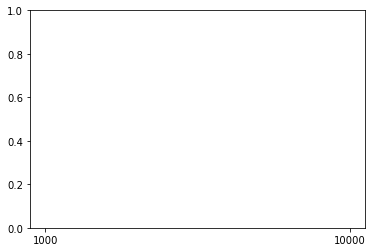

In [25]:
#points =['100','1000','10000','100000']
points =['1000','10000','100000']#Interpretable scale for minimum training points
# metric_pCal = [MAE_pCal, MSE_pCal]
# metric_ML = [MAE_ML, MSE_ML]
# metric_pCal = [MAE_pCal, MSE_pCal, R2_pCal, R2_pCal_train_test]
# metric_ML = [MAE_ML, MSE_ML, R2_ML, R2_ML_train_test]
metric = [metric_ML, metric_pCal]
name = ['MLP','pCal']
ylabels = ['Kelvin','Kelvin^2','R-square','R^2_train/ R^2_test']
titles = ['Mean Absolute Error MLP vs pCal',
          'Mean Square Error MLP vs pCal',
          'R-Square MLP vs pCal',
          'R-Square ratios of MLP vs pCal']

pairs = list(zip(metric_ML,metric_pCal))
for i, (ML, pCal) in enumerate(pairs):   
    for j, label in enumerate(name):
        plt.plot(points, pairs[i][j], label=label)
    plt.title(titles[i])
    plt.legend(loc="center right")
    plt.xlabel("sample size")
    plt.ylabel(ylabels[i])
    
    
    plt.show()   
#for i in range(len(points)):    

In [20]:
#metric = ['MAE','MSE','R-Square','Validation ratio']
metric = ['MAE','MSE']
for i,j in itertools.product(range(len(metric)), range(len(metric))):
    metric_pCal[i][j] = round(metric_pCal[i][j],2)
    metric_ML[i][j] = round(metric_ML[i][j],2)
    

In [23]:
print(metric_ML)
print(metric_pCal)

[[61575.84, 3.75, 3.57, 6.81], [3791584120.08, 30.94, 31.63, 59.69]]
[[61725.72, 4.62, 4.62, 20.2], [3810087515.47, 43.89, 43.91, 450.76]]


In [24]:
import plotly.graph_objects as go

for i in range(len(trainSamp)):
    fig = go.Figure(data=[go.Table(header=dict(values=[f'Metric {points[i]}pts','MLP', 'pCal']),
                     cells=dict(values=[metric, np.array(metric_ML).T[i],  np.array(metric_pCal).T[i]]))
                         ])
    fig.show()

In [ ]:
df.head()